# Installing Dependencies

In [1]:
!pip install yfinance pandas numpy matplotlib seaborn statsmodels arch scikit-learn imbalanced-learn tensorflow torch alpha-vantage pykalman gym xgboost lightgbm prophet --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 45.1 MB/s eta 0:00:00


# Importing Libraries

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical and time series models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model

# Machine Learning models and utilities
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# Deep Learning frameworks
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout, Conv1D, MaxPooling1D, Flatten, Input
from tensorflow.keras.optimizers import Adam

# PyTorch and reinforcement learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.distributions import Categorical
from collections import deque

# Additional libraries
from alpha_vantage.fundamentaldata import FundamentalData
import time
from pykalman import KalmanFilter
import gym
import xgboost as xgb
import lightgbm as lgb
from prophet import Prophet
import random
import re

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/holidays/deprecations/v1_incompatibility.py:40: FutureIncompatibilityWarning: 

This is a future version incompatibility warning from Holidays v0.67
to inform you about an upcoming change in our API versioning strategy that may affect your
project's dependencies. Starting from version 1.0 onwards, we will be following a loose form of
Semantic Versioning (SemVer, https://semver.org) to provide clearer communication regarding any
potential breaking changes.

This means that while we strive to maintain backward compatibility, there might be occasional
updates that introduce breaking changes to our API. To ensure the stability of your pr

# Receive Stock Ticker from User and gather live stock data using online API

In [3]:
# User needs to input their own Alpha Vantage API Key
api_key = "Q9LQ7OBQ13SH1ANT"

def get_valid_ticker():
    """Prompts user for a valid stock ticker and verifies it using Yahoo Finance."""
    while True:
        stock = input("Enter a valid stock ticker (e.g., AAPL, TSLA, MSFT): ").upper()
        try:
            test = yf.Ticker(stock)
            if test.history(period="1d").empty:
                print("Invalid ticker. Please try again.")
            else:
                return stock
        except Exception as e:
            print(f"Error validating ticker: {e}")
            print("Invalid input. Please try again.")

# Get a valid stock ticker from the user
stock_ticker = get_valid_ticker()

# Fetch stock data using Yahoo Finance
ticker = yf.Ticker(stock_ticker)
history = ticker.history(period="10y")

# Display basic stock info
try:
    info = ticker.info
    print(f"\nStock Name: {info.get('longName', 'N/A')}")
    print(f"Sector: {info.get('sector', 'N/A')}")
    print(f"Market Cap: {info.get('marketCap', 'N/A')}")
except Exception as e:
    print(f"Error retrieving stock info: {e}")

Enter a valid stock ticker (e.g., AAPL, TSLA, MSFT): rio

Stock Name: Rio Tinto Group
Sector: Basic Materials
Market Cap: 103449067520


# Fundamental Analysis

In [4]:
# Fundamental Analysis
print(f"\nFundamental Analysis of {stock_ticker} :\n")
fundamentals = {}

if 'marketCap' in info:
    fundamentals["Market Cap"] = info['marketCap']
if 'trailingPE' in info:
    fundamentals["P/E Ratio"] = info['trailingPE']
if 'priceToBook' in info:
    fundamentals["P/B Ratio"] = info['priceToBook']
if 'dividendYield' in info:
    fundamentals["Dividend Yield"] = info['dividendYield']
if 'trailingEps' in info:
    fundamentals["Trailing EPS"] = info['trailingEps']
if 'forwardPE' in info:
    fundamentals["Forward P/E Ratio"] = info['forwardPE']
if 'trailingAnnualDividendYield' in info:
    fundamentals["Trailing Dividend Yield"] = info['trailingAnnualDividendYield']
if 'trailingAnnualDividendRate' in info:
    fundamentals["Trailing Dividend Rate"] = info['trailingAnnualDividendRate']
if 'beta' in info:
    fundamentals["Beta"] = info['beta']
if 'trailingPegRatio' in info:
    fundamentals["Trailing PEG Ratio"] = info['trailingPegRatio']
if 'forwardEps' in info:
    fundamentals["Forward EPS"] = info['forwardEps']

# Print fundamental data
for key, value in fundamentals.items():
    print(f"{key}: {value}")

# Buy/Sell Decision Logic
print(f"\nBuy/Sell Recommendation for {stock_ticker} :\n")

decision = "HOLD"  # Default decision

if "P/E Ratio" in fundamentals and fundamentals["P/E Ratio"] is not None:
    pe = fundamentals["P/E Ratio"]
    if pe < 15:
        decision = "BUY (Undervalued)"
    elif pe > 30:
        decision = "SELL (Overvalued)"

if "P/B Ratio" in fundamentals and fundamentals["P/B Ratio"] is not None:
    pb = fundamentals["P/B Ratio"]
    if pb < 1:
        decision = "BUY (Undervalued based on assets)"
    elif pb > 3:
        decision = "SELL (Overvalued based on assets)"

if "Beta" in fundamentals and fundamentals["Beta"] is not None:
    beta = fundamentals["Beta"]
    if beta > 1.5:
        print(f"{stock_ticker} is a high-volatility stock (Risky).")
    elif beta < 1:
        print(f"{stock_ticker} is a low-volatility stock (Stable).")

if "Dividend Yield" in fundamentals and fundamentals["Dividend Yield"] is not None:
    div_yield = fundamentals["Dividend Yield"]
    if div_yield > 0.03:
        print(f"{stock_ticker} is a good dividend-paying stock.")

print(f"\nFinal Recommendation for {stock_ticker}: {decision}\n")
fundamental_analysis = decision


Fundamental Analysis of RIO :

Market Cap: 103449067520
P/E Ratio: 8.985855
P/B Ratio: 1.8669919
Dividend Yield: 6.33
Trailing EPS: 7.07
Forward P/E Ratio: 9.3152485
Trailing Dividend Yield: 0.06252916
Trailing Dividend Rate: 4.02
Beta: 0.601
Trailing PEG Ratio: None
Forward EPS: 6.82

Buy/Sell Recommendation for RIO :

RIO is a low-volatility stock (Stable).
RIO is a good dividend-paying stock.

Final Recommendation for RIO: BUY (Undervalued)



# Technical Analysis


Technical Analysis :



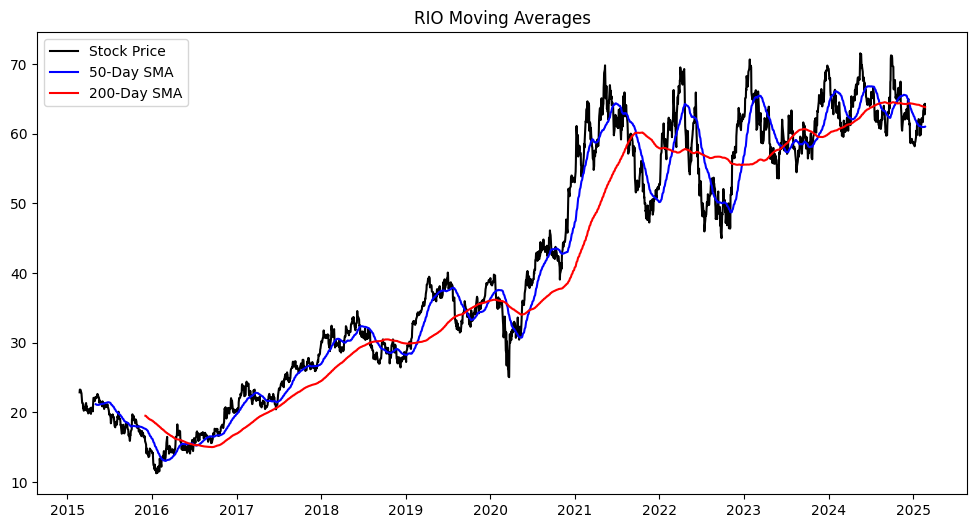


Conclusion :

Bearish Signal: RIO is trending down based on moving averages.


In [5]:
# Technical Analysis
print("\nTechnical Analysis :\n")
history['SMA_50'] = history['Close'].rolling(window=50).mean()
history['SMA_200'] = history['Close'].rolling(window=200).mean()
history['Daily Return'] = history['Close'].pct_change()

# Plot stock price with moving averages
plt.figure(figsize=(12,6))
plt.plot(history['Close'], label='Stock Price', color='black')
plt.plot(history['SMA_50'], label='50-Day SMA', color='blue')
plt.plot(history['SMA_200'], label='200-Day SMA', color='red')
plt.title(f"{stock_ticker} Moving Averages")
plt.legend()
plt.show()

# Check for bullish or bearish trend
print("\nConclusion :\n")
if history['SMA_50'].iloc[-1] > history['SMA_200'].iloc[-1]:
    print(f"Bullish Signal: {stock_ticker} is trending up based on moving averages.")
    technical_analysis = "Buy"
else:
    print(f"Bearish Signal: {stock_ticker} is trending down based on moving averages.")
    technical_analysis = "Sell"

# Time Series Forecasting using ARIMA and ARCH/GARCH


Time Series Forecasting :



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004187. Parameter
estimation work bett


Plot actual vs. predicted for ARIMA :



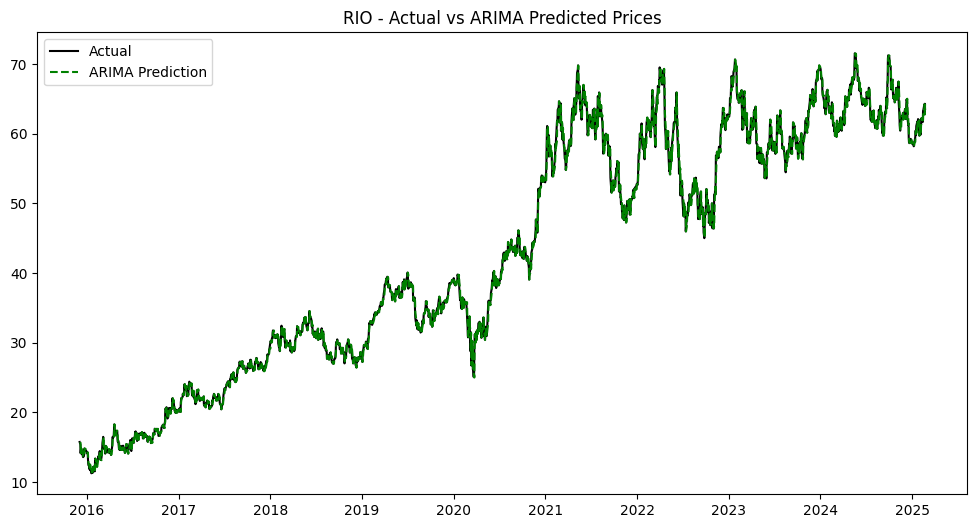


Plot GARCH Volatility :



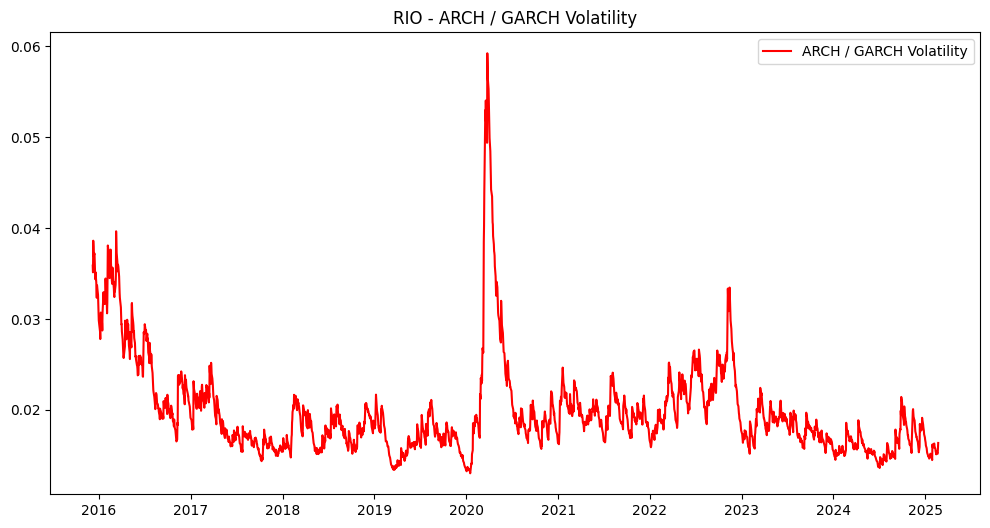


Conclusion :

Sell Signal: RIO's predicted price (63.51) is lower than the current price (63.53).
Stable volatility for RIO. Market is relatively calm.




/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [6]:
# Time Series Forecasting using ARIMA and ARCH/GARCH
print("\nTime Series Forecasting :\n")

# Prepare data for ARIMA
history.dropna(inplace=True)
returns = history['Close'].pct_change().dropna()

# ARIMA Model
arima_model = ARIMA(history['Close'], order=(5,1,0))
arima_result = arima_model.fit()
history['ARIMA_Prediction'] = arima_result.predict(start=history.index[1], end=history.index[-1], dynamic=False)

# ARCH/GARCH Model
garch_model = arch_model(returns, vol='Garch', p=1, q=1)
garch_result = garch_model.fit(disp='off')
history['GARCH_Volatility'] = garch_result.conditional_volatility

# Plot actual vs. predicted for ARIMA
print("\nPlot actual vs. predicted for ARIMA :\n")
plt.figure(figsize=(12,6))
plt.plot(history['Close'], label='Actual', color='black')
plt.plot(history['ARIMA_Prediction'], label='ARIMA Prediction', linestyle='dashed', color='green')
plt.title(f"{stock_ticker} - Actual vs ARIMA Predicted Prices")
plt.legend()
plt.show()

# Plot GARCH Volatility
print("\nPlot GARCH Volatility :\n")
plt.figure(figsize=(12,6))
plt.plot(history['GARCH_Volatility'], label='ARCH / GARCH Volatility', color='red')
plt.title(f"{stock_ticker} - ARCH / GARCH Volatility")
plt.legend()
plt.show()

# Detailed Conclusion
print("\nConclusion :\n")
arima_forecast = arima_result.forecast(steps=1)
arima_forecast_value = arima_forecast.iloc[-1]  # Ensure correct indexing
if arima_forecast_value > history['Close'].iloc[-1]:
    print(f"Buy Signal: {stock_ticker}'s predicted price ({arima_forecast_value:.2f}) is higher than the current price ({history['Close'].iloc[-1]:.2f}).")
    time_series_forecasting = "Buy"
else:
    print(f"Sell Signal: {stock_ticker}'s predicted price ({arima_forecast_value:.2f}) is lower than the current price ({history['Close'].iloc[-1]:.2f}).")
    time_series_forecasting = "Sell"

if history['GARCH_Volatility'].iloc[-1] > history['GARCH_Volatility'].mean():
    print(f"High volatility detected for {stock_ticker}. Trade with caution.\n\n")
else:
    print(f"Stable volatility for {stock_ticker}. Market is relatively calm.\n\n")

# Linear Regression

Linear Regression :

Model Evaluation :

Mean Absolute Error: 4.682856605538877
Mean Squared Error: 40.156294905191665
R-Squared Score: 0.8727768983731525


RIO Price Prediction using Linear Regression :



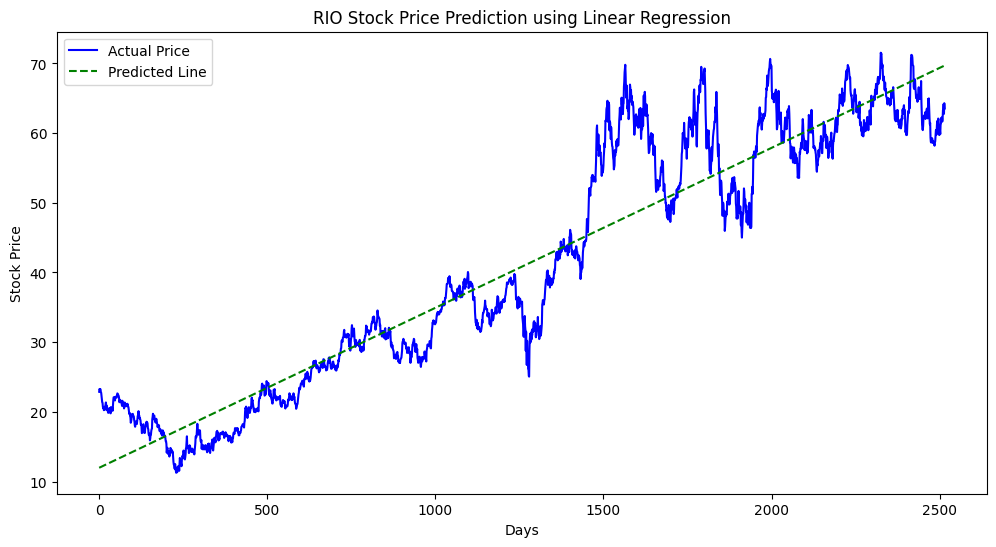


Conclusion :

Buy Signal: Predicted price (69.72) is higher than the current price (63.53).




/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [7]:
# Fetch data from Yahoo Finance for 10+ years
history = ticker.history(period="10y")

# Prepare data for Linear Regression
history = history.dropna()
history['Date'] = history.index
df = history[['Close']].reset_index(drop=True)
df['Day'] = np.arange(len(df))

# Split data into training and testing sets
X = df[['Day']]
y = df['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print model evaluation
print("Linear Regression :\n")
print("Model Evaluation :\n")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-Squared Score: {r2}\n")

print(f"\n{stock_ticker} Price Prediction using Linear Regression :\n")
# Plot actual vs predicted prices
plt.figure(figsize=(12,6))
plt.plot(df['Day'], df['Close'], label='Actual Price', color='blue')
plt.plot(df['Day'], model.predict(X), label='Predicted Line', color='green', linestyle='dashed')
plt.title(f"{stock_ticker} Stock Price Prediction using Linear Regression")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

# Conclusion based on prediction
latest_predicted_price = model.predict([[df['Day'].iloc[-1] + 1]])[0]
current_price = df['Close'].iloc[-1]

print("\nConclusion :\n")
if latest_predicted_price > current_price:
    print(f"Buy Signal: Predicted price ({latest_predicted_price:.2f}) is higher than the current price ({current_price:.2f}).\n\n")
    linear_regression_model = "Buy"
else:
    print(f"Sell Signal: Predicted price ({latest_predicted_price:.2f}) is lower than the current price ({current_price:.2f}).\n\n")
    linear_regression_model = "Sell"

# Logistic Regression Model


Logistic Regression Model 

Best Hyperparameters: {'C': 100}
Accuracy: 0.4537987679671458

Classification Report:

               precision    recall  f1-score   support

           0       0.48      0.38      0.42       256
           1       0.44      0.53      0.48       231

    accuracy                           0.45       487
   macro avg       0.46      0.46      0.45       487
weighted avg       0.46      0.45      0.45       487


Confusion Matrix :



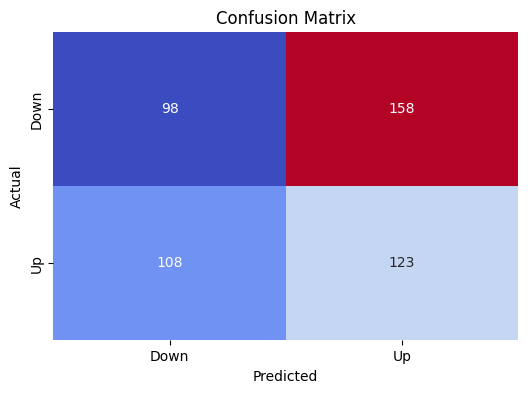


RIO Price Prediction using Logistic Regression :



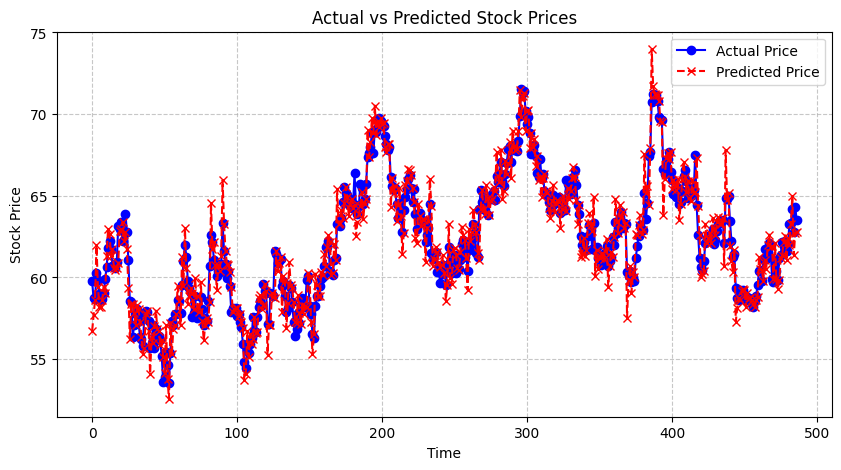


Conclusion :

Buy Recommendation: The model predicts an upward trend for RIO.



In [8]:
# Ensure 'Daily Return' is computed correctly
if 'Daily Return' not in history.columns:
    history['Daily Return'] = history['Close'].pct_change()

# Add more technical indicators
history['Momentum'] = history['Close'] - history['Close'].shift(4)
history['Volatility'] = history['Daily Return'].rolling(window=5).std()
history['SMA_10'] = history['Close'].rolling(window=10).mean()

# Ensure SMA_50 and SMA_200 are computed
history['SMA_50'] = history['Close'].rolling(window=50).mean()
history['SMA_200'] = history['Close'].rolling(window=200).mean()

# Logistic Regression Model for Predicting Stock Movement
print("\nLogistic Regression Model \n")
history['Target'] = (history['Close'].shift(-1) > history['Close']).astype(int)

features = ['SMA_50', 'SMA_200', 'Daily Return', 'Momentum', 'Volatility', 'SMA_10']

# Drop rows where any feature or target is NaN
history.dropna(subset=features + ['Target'], inplace=True)

X = history[features]
y = history['Target']

# Balance dataset using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)

# Hyperparameter tuning with GridSearchCV
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

model = grid_search.best_estimator_
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Map predicted movements to actual prices
predicted_prices = history['Close'].iloc[-len(y_test):].values * (1 + (y_pred * 2 - 1) * history['Daily Return'].iloc[-len(y_test):].values)

print("Best Hyperparameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n\n", classification_report(y_test, y_pred))

print(f"\nConfusion Matrix :\n")
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print(f"\n{stock_ticker} Price Prediction using Logistic Regression :\n")
plt.figure(figsize=(10,5))
plt.plot(history['Close'].iloc[-len(y_test):].values, label="Actual Price", color="blue", marker='o', linestyle='-')
plt.plot(predicted_prices, label="Predicted Price", color="red", marker='x', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.title("Actual vs Predicted Stock Prices")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print("\nConclusion :\n")
if y_pred[-1] == 1:
    print(f"Buy Recommendation: The model predicts an upward trend for {stock_ticker}.\n")
    logistic_regression_model = "Buy"
else:
    print(f"Sell Recommendation: The model predicts a downward trend for {stock_ticker}.\n")
    logistic_regression_model = "Sell"

# Random Forest Regressor & Classifier


RIO Price Prediction using Random Forest Regressor & Classifier :

Regression Model Performance :

Mean Absolute Error: 0.21172219093503633
Mean Squared Error: 0.08887298514180927

Classification Model Performance :

Accuracy: 0.5107758620689655

RIO Actual vs Predicted Prices using Random Forest Regressor & Classifier :



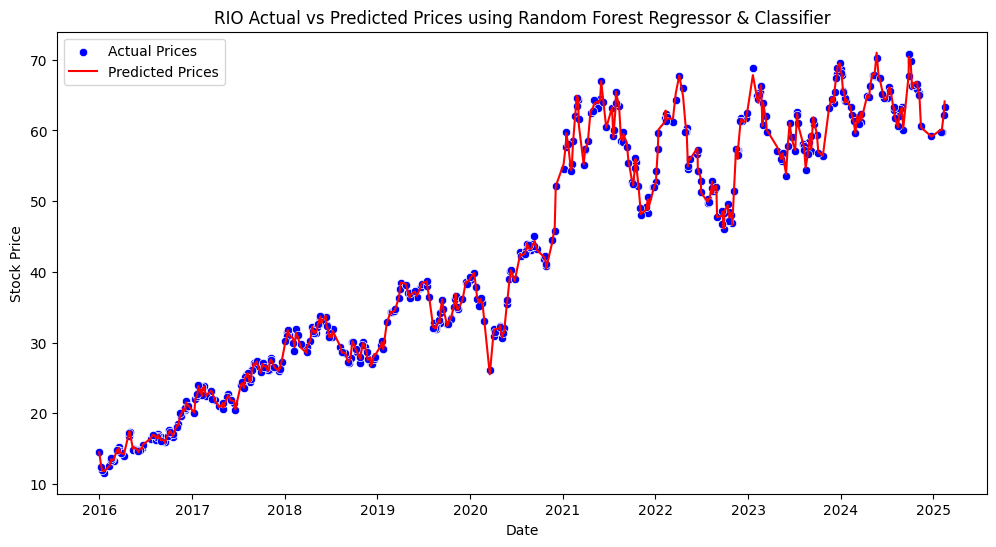


Conclusion :

Sell Signal: RIO is predicted to go down.



In [9]:
# Fetch historical stock data
def fetch_stock_data(stock_ticker):
    ticker = yf.Ticker(stock_ticker)
    history = ticker.history(period="10y")
    return history

# Get stock ticker from user
history = fetch_stock_data(stock_ticker)

# Prepare data for prediction
history['Returns'] = history['Close'].pct_change()
history['SMA_50'] = history['Close'].rolling(window=50).mean()
history['SMA_200'] = history['Close'].rolling(window=200).mean()
history.dropna(inplace=True)

# Feature selection and target variable
features = ['SMA_50', 'SMA_200', 'Open', 'High', 'Low', 'Volume']
X = history[features]
y_reg = history['Close']  # For regression
y_clf = (history['Returns'] > 0).astype(int)  # Classification: 1 if return > 0 else 0

# Split data
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.2, random_state=42)

# Train Random Forest Regressor
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train, y_train_reg)
y_pred_reg = regressor.predict(X_test)

# Train Random Forest Classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train_clf, y_train_clf)
y_pred_clf = classifier.predict(X_test_clf)

# Performance evaluation
print(f"\n{stock_ticker} Price Prediction using Random Forest Regressor & Classifier :")
print("\nRegression Model Performance :\n")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_reg, y_pred_reg)}")
print(f"Mean Squared Error: {mean_squared_error(y_test_reg, y_pred_reg)}")

print("\nClassification Model Performance :\n")
print(f"Accuracy: {accuracy_score(y_test_clf, y_pred_clf)}\n")

print(f"{stock_ticker} Actual vs Predicted Prices using Random Forest Regressor & Classifier :\n")
# Improved graph with scatter plot and trend lines
plt.figure(figsize=(12,6))
sns.scatterplot(x=y_test_reg.index, y=y_test_reg, label='Actual Prices', color='blue')
sns.lineplot(x=y_test_reg.index, y=y_pred_reg, label='Predicted Prices', color='red')
plt.title(f"{stock_ticker} Actual vs Predicted Prices using Random Forest Regressor & Classifier")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

# Conclusion
print("\nConclusion :\n")
if y_pred_clf[-1] == 1:
    print(f"Buy Signal: {stock_ticker} is predicted to go up.\n")
    random_forest = "Buy"
else:
    print(f"Sell Signal: {stock_ticker} is predicted to go down.\n")
    random_forest = "Sell"

# Support Vector Machine (SVM)

[*********************100%***********************]  1 of 1 completed

YF.download() has changed argument auto_adjust default to True



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



RIO Actual vs Predicted Prices using SVM :



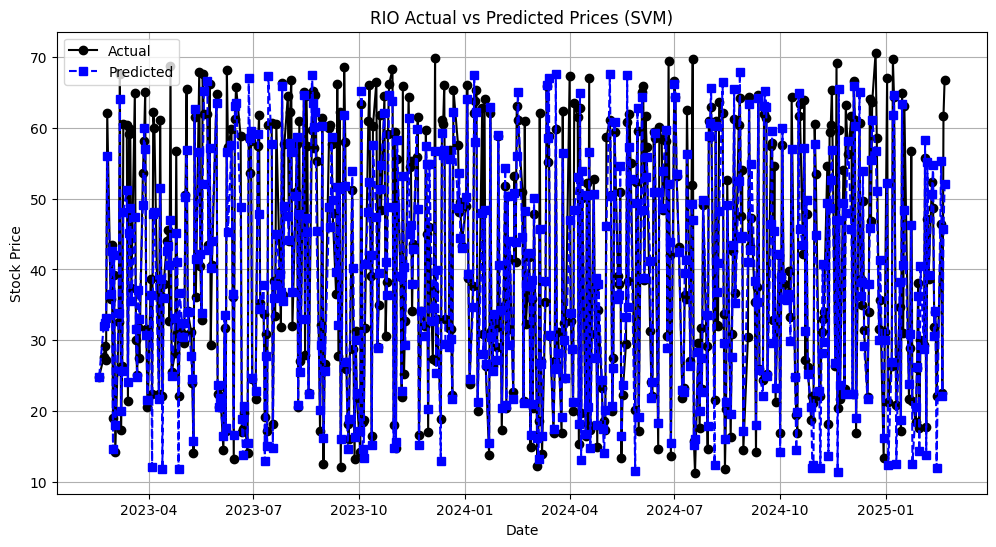


Conclusion :

Mean Squared Error: 41.64553485597158
R-squared Score: 0.8680586910272767

Prediction: Price is expected to rise. Consider BUYING RIO.


In [10]:
# Fetch 10-year historical data
history = yf.download(stock_ticker, period="10y")

# Prepare data for SVM
history.dropna(inplace=True)
history['Date'] = history.index
history['Date'] = history['Date'].map(pd.Timestamp.toordinal)

X = history[['Date']]
y = history['Close']

# Normalize data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train SVM model
svm_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svm_model.fit(X_train, y_train)

# Predictions
y_pred = svm_model.predict(X_test)

# Plot actual vs predicted
print(f"\n{stock_ticker} Actual vs Predicted Prices using SVM :\n")
plt.figure(figsize=(12,6))
plt.plot(history.index[-len(y_test):], y_test.values, label='Actual', color='black', marker='o')
plt.plot(history.index[-len(y_test):], y_pred, label='Predicted', color='blue', linestyle='dashed', marker='s')
plt.title(f"{stock_ticker} Actual vs Predicted Prices (SVM)")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation
print("\nConclusion :\n")
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}\n")

# Conclusion: Buy or Sell
latest_predicted = svm_model.predict(scaler.transform([[history['Date'].iloc[-1]]])).item()
latest_actual = history['Close'].iloc[-1].item()

if latest_predicted > latest_actual:
    print(f"Prediction: Price is expected to rise. Consider BUYING {stock_ticker}.")
    svm_model = "Buy"
else:
    print(f"Prediction: Price is expected to drop. Consider SELLING {stock_ticker}.")
    svm_model = "Sell"

# XGBoost & LightGBM


XGBoost Model :

XGBoost RMSE: 0.9516588623027524
XGBoost R2 Score: 0.9971960524812682

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 2011, number of used features: 2
[LightGBM] [Info] Start training from score 40.847535

LightGBM Model :

LightGBM RMSE: 0.8861747413413361
LightGBM R2 Score: 0.9975686581674562


RIO Price Trend Over 10 Years :



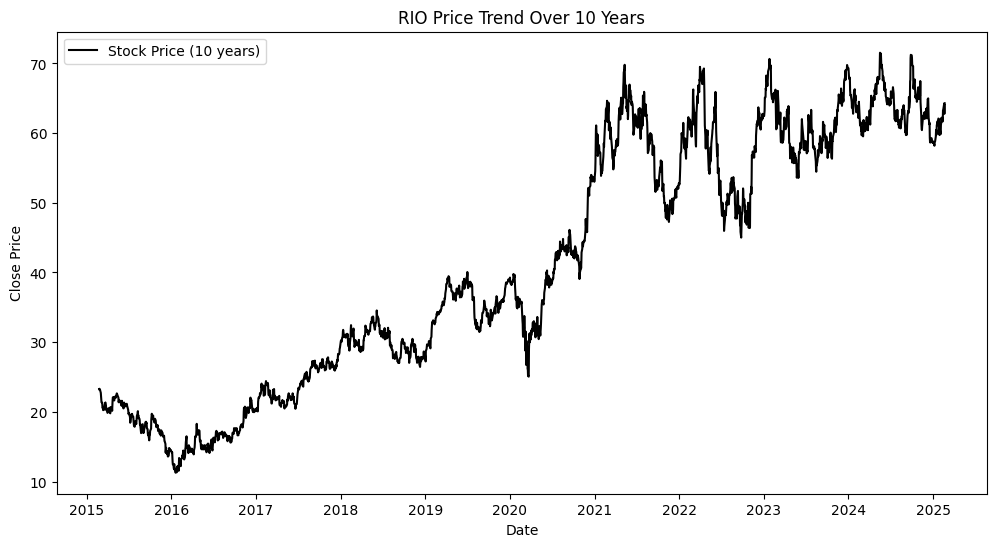


RIO Actual vs Predicted Prices :



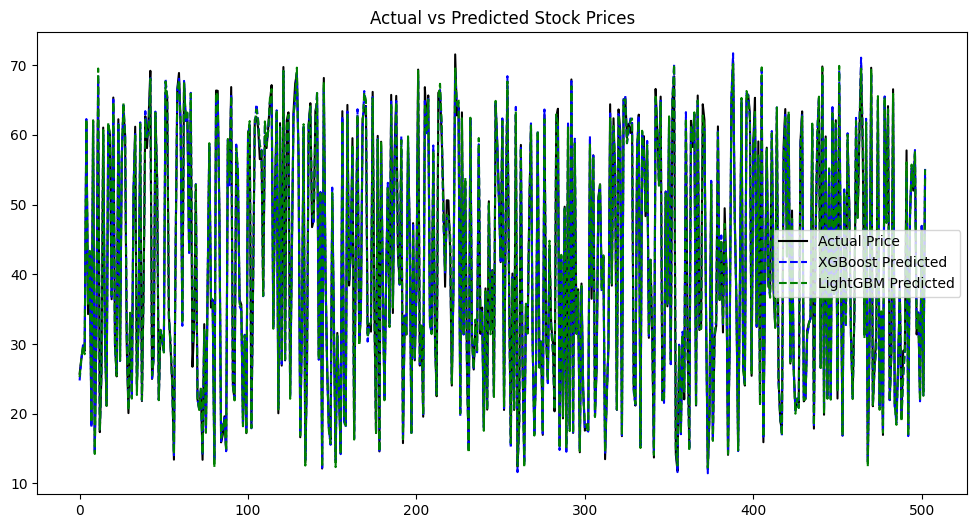


Conclusion :

Both models predict a downward trend. Suggested action: SELL RIO.


In [11]:
# Fetch 10-year historical data
data = history[['Close']].dropna()
data = data[-2520:]  # Approx. 252 trading days per year * 10 years
data['Returns'] = data['Close'].pct_change()
data.dropna(inplace=True)
data['Future_Close'] = data['Close'].shift(-1)  # Renamed to avoid issues
data.dropna(inplace=True)

X = data[['Close', 'Returns']]
y = data['Future_Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert MultiIndex columns to a standard Index
if isinstance(X_train.columns, pd.MultiIndex):
    X_train.columns = ['_'.join(col).strip() for col in X_train.columns]
    X_test.columns = ['_'.join(col).strip() for col in X_test.columns]

# Rename columns to remove special characters
X_train.columns = [re.sub(r'[^a-zA-Z0-9_]', '', col) for col in X_train.columns]
X_test.columns = [re.sub(r'[^a-zA-Z0-9_]', '', col) for col in X_test.columns]

# XGBoost Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
xgb_r2 = r2_score(y_test, xgb_preds)
print("\nXGBoost Model :\n")
print(f"XGBoost RMSE: {xgb_rmse}")
print(f"XGBoost R2 Score: {xgb_r2}\n")

# LightGBM Model
lgb_model = lgb.LGBMRegressor(n_estimators=100)
lgb_model.fit(X_train, y_train)
lgb_preds = lgb_model.predict(X_test)

lgb_rmse = np.sqrt(mean_squared_error(y_test, lgb_preds))
lgb_r2 = r2_score(y_test, lgb_preds)
print("\nLightGBM Model :\n")
print(f"LightGBM RMSE: {lgb_rmse}")
print(f"LightGBM R2 Score: {lgb_r2}\n")

# Price Graph Over 10 Years
print(f"\n{stock_ticker} Price Trend Over 10 Years :\n")
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Close'], label="Stock Price (10 years)", color='black')
plt.title(f"{stock_ticker} Price Trend Over 10 Years")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# Graph Comparing Actual vs Predicted Prices
print(f"\n{stock_ticker} Actual vs Predicted Prices :\n")
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Actual Price", color='black')
plt.plot(xgb_preds, label="XGBoost Predicted", linestyle='dashed', color='blue')
plt.plot(lgb_preds, label="LightGBM Predicted", linestyle='dashed', color='green')
plt.title("Actual vs Predicted Stock Prices")
plt.legend()
plt.show()

# Conclusion on Buy or Sell Decision
latest_close = history['Close'].iloc[-1].item()  # Ensure scalar value
xgb_latest_pred = xgb_preds[-1]
lgb_latest_pred = lgb_preds[-1]

print("\nConclusion :\n")
if xgb_latest_pred > latest_close and lgb_latest_pred > latest_close:
    print(f"Both models predict an upward trend. Suggested action: BUY {stock_ticker}.")
    xgboost_lightgbm_model = "Buy"
elif xgb_latest_pred < latest_close and lgb_latest_pred < latest_close:
    print(f"Both models predict a downward trend. Suggested action: SELL {stock_ticker}.")
    xgboost_lightgbm_model = "Sell"
else:
    print(f"Models have mixed predictions. Suggested action: HOLD {stock_ticker}, observe further.")
    xgboost_lightgbm_model = "Hold"


# Artificial Neural Networks (ANN)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

RIO Actual vs. Predicted Prices (ANN) :



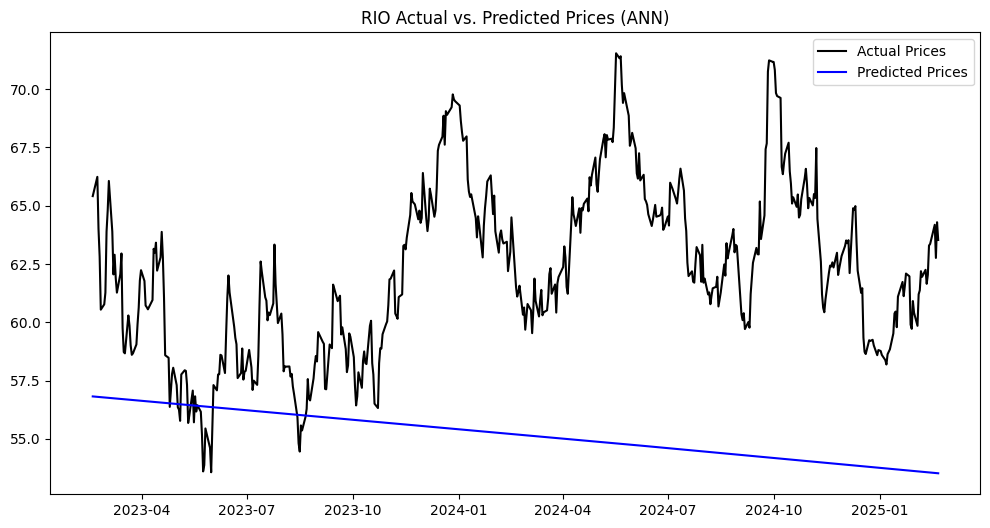


Conclusion :

SELL Signal: RIO's price is predicted to decrease.


In [12]:
# Fetch 10 years of data
history = ticker.history(period="10y")
history['Date'] = history.index
history['Ordinal Date'] = history['Date'].map(pd.Timestamp.toordinal)
features = ['Ordinal Date']
X = history[features].values
Y = history['Close'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
Y_scaled = scaler.fit_transform(Y.reshape(-1, 1))

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2, shuffle=False)

# Define ANN Model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, Y_train, epochs=100, batch_size=16, verbose=0)

# Predictions
Y_pred = model.predict(X_test)
Y_pred_rescaled = scaler.inverse_transform(Y_pred)
Y_test_rescaled = scaler.inverse_transform(Y_test)

# Plot Actual vs. Predicted Prices
print(f"\n{stock_ticker} Actual vs. Predicted Prices (ANN) :\n")
plt.figure(figsize=(12,6))
plt.plot(history.index[-len(Y_test):], Y_test_rescaled, label='Actual Prices', color='black')
plt.plot(history.index[-len(Y_pred):], Y_pred_rescaled, label='Predicted Prices', color='blue')
plt.title(f"{stock_ticker} Actual vs. Predicted Prices (ANN)")
plt.legend()
plt.show()

# Buy/Sell Conclusion
print("\nConclusion :\n")
if Y_pred_rescaled[-1] > Y_test_rescaled[-1]:
    print(f"BUY Signal: {stock_ticker}'s price is predicted to increase.")
    ann_model = "Buy"

else:
    print(f"SELL Signal: {stock_ticker}'s price is predicted to decrease.")
    ann_model = "Sell"

# Recurrent Neural Networks (RNN)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 65s 676ms/step - loss: 0.0463
Epoch 2/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 94s 810ms/step - loss: 0.0013
Epoch 3/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 58s 544ms/step - loss: 0.0014
Epoch 4/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 50s 558ms/step - loss: 0.0010
Epoch 5/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 48s 545ms/step - loss: 0.0010
Epoch 6/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 81s 539ms/step - loss: 0.0010
Epoch 7/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 83s 546ms/step - loss: 0.0011
Epoch 8/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 49s 549ms/step - loss: 9.2398e-04
Epoch 9/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 82s 553ms/step - loss: 8.1301e-04
Epoch 10/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 82s 558ms/step - loss: 6.9935e-04
Epoch 11/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 81s 553ms/step - loss: 7.2962e-04
Epoch 12/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 49s 548ms/step - loss: 6.0973e-04
Epoch 13/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 82s 541ms/step - loss: 5.6734e-04
Epoch 14/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 48s 545ms/step - loss: 5.3742e-04
Epoch 15/20
89/89 ━━━━━━━━

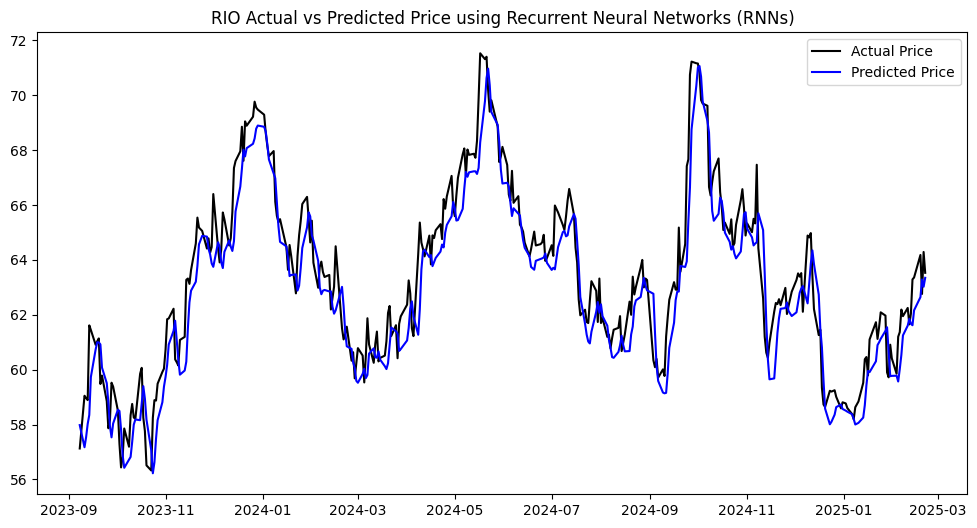


Conclusion :

Last Actual Price: 63.529998779296875
Last Predicted Price: 63.34847640991211
Prediction suggests a downward trend. Consider SELLING RIO.



In [13]:
# Prepare data for RNN
scaler = MinMaxScaler(feature_range=(0,1))
data = history[['Close']].copy()
data_scaled = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 730  # Use last 2 years (730 days) to predict the next day
X, y = create_sequences(data_scaled, seq_length)
X_train, y_train = X[:-365], y[:-365]
X_test, y_test = X[-365:], y[-365:]

# Build RNN Model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(units=50, return_sequences=False),
    Dense(units=25),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train Model
model.fit(X_train, y_train, batch_size=16, epochs=20)

# Predict
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

# Plot results
print(f"\n\n{stock_ticker} : Actual vs Predicted Price using Recurrent Neural Networks (RNNs) :\n")
plt.figure(figsize=(12,6))
plt.plot(data.index[-365:], y_test_rescaled, label='Actual Price', color='black')
plt.plot(data.index[-365:], y_pred_rescaled, label='Predicted Price', color='blue')
plt.title(f"{stock_ticker} Actual vs Predicted Price using Recurrent Neural Networks (RNNs)")
plt.legend()
plt.show()

# Conclusion
last_predicted = y_pred_rescaled[-1][0]
last_actual = y_test_rescaled[-1][0]
print("\nConclusion :\n")
print(f"Last Actual Price: {last_actual}")
print(f"Last Predicted Price: {last_predicted}")

if last_predicted > last_actual:
    print(f"Prediction suggests an upward trend. Consider BUYING {stock_ticker}.\n")
    rnn_model = "Buy"
elif last_predicted < last_actual:
    print(f"Prediction suggests a downward trend. Consider SELLING {stock_ticker}.\n")
    rnn_model = "Sell"
else:
    print(f"Prediction suggests stability. Hold your position in {stock_ticker}.\n")
    rnn_model = "Hold"

# Long Short-Term Memory (LSTM)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - loss: 0.0352 - val_loss: 0.0018
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 0.0030 - val_loss: 0.0036
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0018 - val_loss: 8.5525e-04
Epoch 7/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 8/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 9/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0015 - val_loss: 9.3028e-04
Epoch 10/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.0013 - val_loss: 6.5709e-04
Epoch 11/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - loss: 0.0012 - val_loss: 6.6365e-04
Epoch 12/50
124/124 ━━━━━━━━━━━━━

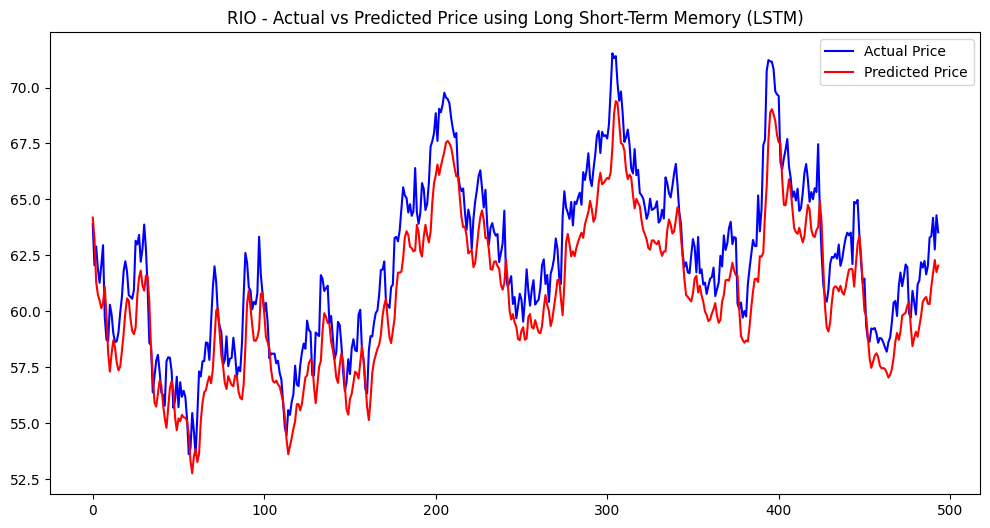


Conclusion :

Sell Signal: RIO's predicted price (62.04) is lower than its current price (63.53).



In [14]:
# Fetch data from previous analysis
data = history[['Close']]
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data)

# Prepare data for LSTM model
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 50  # Higher number for higher accuracy
X, y = create_sequences(data_scaled, seq_length)
X_train, X_test = X[:int(0.8 * len(X))], X[int(0.8 * len(X)):]
y_train, y_test = y[:int(0.8 * len(y))], y[int(0.8 * len(y)):]

# Build LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

# Make predictions
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted
print(f"\n\n{stock_ticker} Price Prediction using Long Short-Term Memory (LSTM) :\n")
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual Price', color='blue')
plt.plot(y_pred_inv, label='Predicted Price', color='red')
plt.title(f"{stock_ticker} - Actual vs Predicted Price using Long Short-Term Memory (LSTM)")
plt.legend()
plt.show()

# Conclusion
latest_pred = y_pred_inv[-1][0]
latest_actual = y_test_inv[-1][0]
print("\nConclusion :\n")
if latest_pred > latest_actual:
    print(f"Buy Signal: {stock_ticker}'s predicted price ({latest_pred:.2f}) is higher than its current price ({latest_actual:.2f}).\n")
    lstm_model = "Buy"
else:
    print(f"Sell Signal: {stock_ticker}'s predicted price ({latest_pred:.2f}) is lower than its current price ({latest_actual:.2f}).\n")
    lstm_model = "Sell"

# Gated Recurrent Units (GRU)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - loss: 0.0375 - val_loss: 0.0028
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0027 - val_loss: 7.4166e-04
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 0.0018 - val_loss: 7.0656e-04
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 0.0014 - val_loss: 4.8225e-04
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - loss: 0.0012 - val_loss: 5.3410e-04
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0011 - val_loss: 4.2674e-04
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - loss: 9.2278e-04 - val_loss: 4.0930e-04
Epoch 12/20
124/1

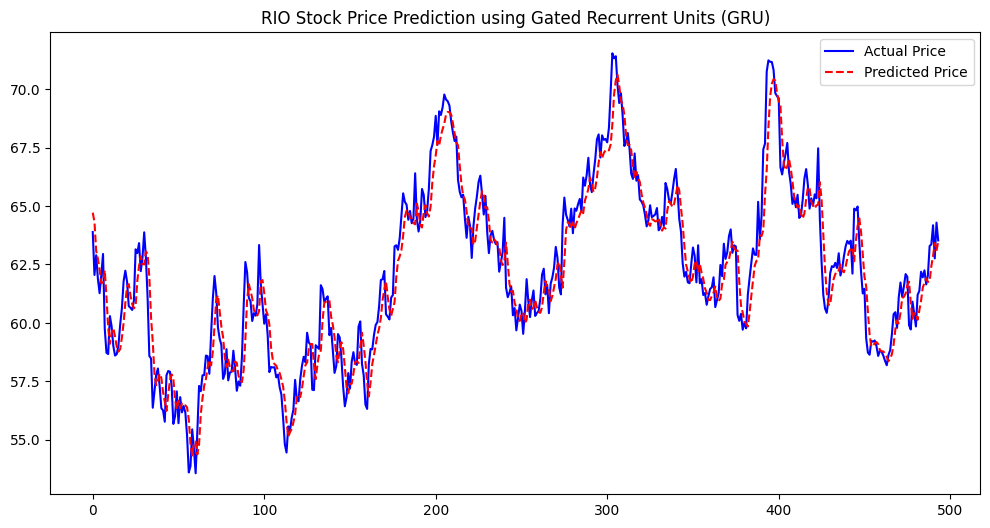


Conclusion :

Minor price change (-0.08%). Suggested action: HOLD


In [15]:
time_steps = 50  # Number of time steps to look back

def create_sequences(data, time_steps):
    sequences, labels = [], []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:i + time_steps])
        labels.append(data[i + time_steps])
    return np.array(sequences), np.array(labels)

# Prepare data for GRU model
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(history[['Close']])
X, y = create_sequences(scaled_data, time_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build GRU Model
model = Sequential([
    GRU(units=50, return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(0.2),
    GRU(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

# Make predictions
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted values
print(f"\n\n{stock_ticker} Price Prediction using Gated Recurrent Units (GRU) :\n")
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual Price', color='blue')
plt.plot(y_pred_inv, label='Predicted Price', color='red', linestyle='dashed')
plt.title(f'{stock_ticker} Stock Price Prediction using Gated Recurrent Units (GRU)')
plt.legend()
plt.show()

# Conclusion
last_actual = y_test_inv[-1][0]
last_predicted = y_pred_inv[-1][0]
price_change = ((last_predicted - last_actual) / last_actual) * 100

print("\nConclusion :\n")
if price_change > 1:
    print(f"Predicted price increase: {price_change:.2f}%. Suggested action: BUY")
    gru_model = "Buy"
elif price_change < -1:
    print(f"Predicted price decrease: {price_change:.2f}%. Suggested action: SELL")
    gru_model = "Sell"
else:
    print(f"Minor price change ({price_change:.2f}%). Suggested action: HOLD")
    gru_model = "Hold"

# Transformer Models

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/20, Loss: 0.0073
Epoch 2/20, Loss: 0.0047
Epoch 3/20, Loss: 0.0034
Epoch 4/20, Loss: 0.0012
Epoch 5/20, Loss: 0.0012
Epoch 6/20, Loss: 0.0011
Epoch 7/20, Loss: 0.0019
Epoch 8/20, Loss: 0.0007
Epoch 9/20, Loss: 0.0012
Epoch 10/20, Loss: 0.0006
Epoch 11/20, Loss: 0.0011
Epoch 12/20, Loss: 0.0007
Epoch 13/20, Loss: 0.0002
Epoch 14/20, Loss: 0.0023
Epoch 15/20, Loss: 0.0007
Epoch 16/20, Loss: 0.0006
Epoch 17/20, Loss: 0.0006
Epoch 18/20, Loss: 0.0013
Epoch 19/20, Loss: 0.0010
Epoch 20/20, Loss: 0.0007


RIO Price Prediction using Transformer model :



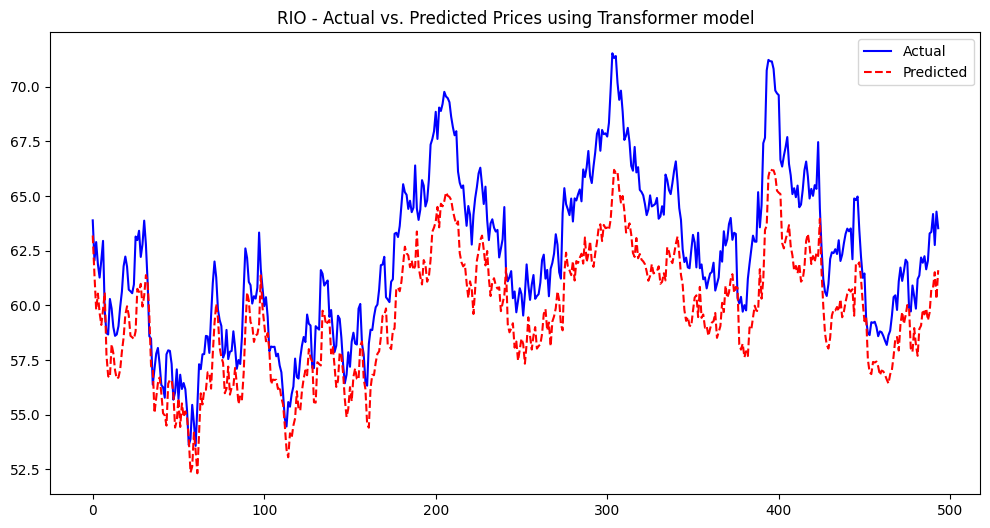


Conclusion :

Predicted price is lower than the current price. Consider Selling RIO.


In [16]:
# Data Preprocessing
scaler = MinMaxScaler()
history['Scaled_Close'] = scaler.fit_transform(history[['Close']])

# Prepare data for Transformer model
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 50
X, y = create_sequences(history['Scaled_Close'].values, seq_length)
X_train, X_test = X[:int(0.8*len(X))], X[int(0.8*len(X)):]
y_train, y_test = y[:int(0.8*len(y))], y[int(0.8*len(y)):]

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, hidden_dim, num_layers):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim),
            num_layers=num_layers
        )
        self.fc = nn.Linear(embed_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        x = self.fc(x[:, -1, :])
        return x

# Initialize model
model = TransformerModel(input_dim=1, embed_dim=64, num_heads=4, hidden_dim=128, num_layers=2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20 # Higher number for higher accuracy
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch.unsqueeze(-1))
        loss = criterion(y_pred.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Predictions
model.eval()
y_pred_list = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        y_pred = model(X_batch.unsqueeze(-1))
        y_pred_list.extend(y_pred.squeeze().tolist())

# Inverse scale
y_pred_list = scaler.inverse_transform(np.array(y_pred_list).reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot Actual vs Predicted
print(f"\n\n{stock_ticker} Price Prediction using Transformer model :\n")
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual', color='blue')
plt.plot(y_pred_list, label='Predicted', color='red', linestyle='dashed')
plt.title(f"{stock_ticker} - Actual vs. Predicted Prices using Transformer model")
plt.legend()
plt.show()

# Buy/Sell Recommendation
print("\nConclusion :\n")
if y_pred_list[-1] > y_test_actual[-1]:
    print(f"Predicted price is higher than the current price. Consider Buying {stock_ticker}.")
    transformer_model = "Buy"
else:
    print(f"Predicted price is lower than the current price. Consider Selling {stock_ticker}.")
    transformer_model = "Sell"

# SARIMA Model


 SARIMA Model Forecasting :

ADF Statistic: -1.0954394470615039
p-value: 0.7168871699922149
The data is not stationary.



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(




RIO Price Prediction using SARIMA :



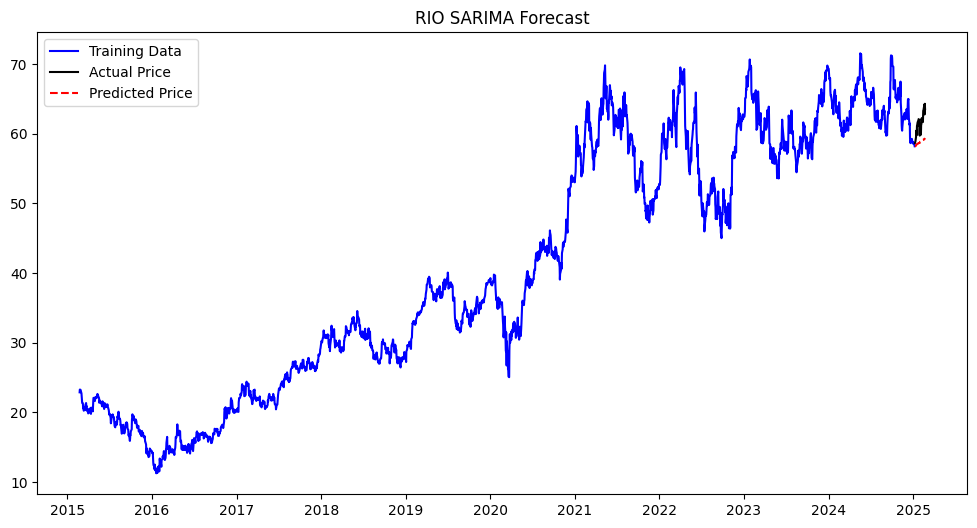


Conclusion :

Sell Signal: RIO is expected to drop based on SARIMA prediction.


In [17]:
print("\n SARIMA Model Forecasting :\n")

# Checking stationarity
def check_stationarity(series):
    result = adfuller(series.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] < 0.05:
        print("The data is stationary.\n")
    else:
        print("The data is not stationary.\n")

# Ensure 'Close' column exists before proceeding
if 'Close' not in history.columns:
    print("\nError: 'Close' column not found in the data. Check the ticker or data source.\n")
    exit()

check_stationarity(history['Close'])

# Handle missing values
if history['Close'].isna().all():
    print("\nError: 'Close' column has all NaN values. Exiting...\n")
    exit()
history['Close'] = history['Close'].ffill()

# Fit SARIMA model
train = history['Close'][:-30]  # Use all but last 30 days for training
test = history['Close'][-30:]

model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)

# Forecast
forecast = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

# Plot actual vs predicted
print(f"\n\n{stock_ticker} Price Prediction using SARIMA :\n")
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Actual Price', color='black')
plt.plot(test.index, forecast, label='Predicted Price', color='red', linestyle='dashed')
plt.title(f"{stock_ticker} SARIMA Forecast")
plt.legend()
plt.show()

# Conclusion
print("\nConclusion :\n")
if forecast.iloc[-1] > test.iloc[-1]:
    print(f"Buy Signal: {stock_ticker} is expected to rise based on SARIMA prediction.")
    sarima_model = "Buy"
else:
    print(f"Sell Signal: {stock_ticker} is expected to drop based on SARIMA prediction.")
    sarima_model = "Sell"

# Prophet model

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'Date', 'Ordinal Date', 'Scaled_Close'],
      dtype='object')


DEBUG:cmdstanpy:input tempfile: /tmp/tmpwxhizq__/3i8b5vv8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwxhizq__/b9gokkbf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79877', 'data', 'file=/tmp/tmpwxhizq__/3i8b5vv8.json', 'init=/tmp/tmpwxhizq__/b9gokkbf.json', 'output', 'file=/tmp/tmpwxhizq__/prophet_modelqhsdwlh_/prophet_model-20250223113027.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:30:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:30:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing




RIO Price Prediction using Prophet :



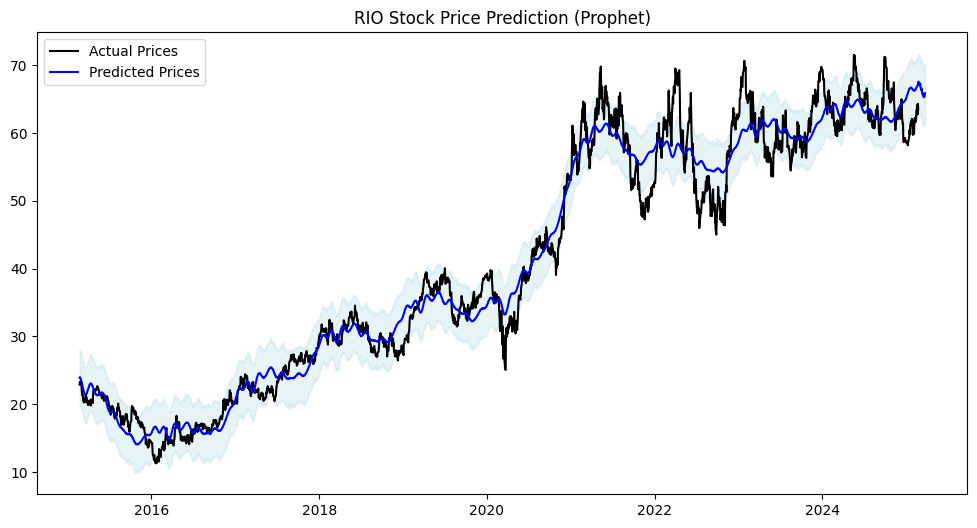


Conclusion :

Current Price: 63.53
Predicted Price (Next 30 days): 65.87
Buy Signal: Price expected to increase.


In [18]:
# Prepare data for Prophet
history = history.reset_index(drop=True)  # Fix: Prevent duplicate index columns
print(history.columns)  # Debugging: Print column names
history = history[['ds', 'y']] if 'ds' in history.columns else history[['Date', 'Close']]
history.columns = ['ds', 'y']  # Prophet requires 'ds' for date and 'y' for values
history['ds'] = history['ds'].dt.tz_localize(None)  # Remove timezone

# Initialize and fit Prophet model
model = Prophet()
model.fit(history)

# Create future dataframe for prediction
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plot actual vs predicted
print(f"\n\n{stock_ticker} Price Prediction using Prophet :\n")
plt.figure(figsize=(12, 6))
plt.plot(history['ds'], history['y'], label='Actual Prices', color='black')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted Prices', color='blue')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='lightblue', alpha=0.3)
plt.title(f"{stock_ticker} Stock Price Prediction (Prophet)")
plt.legend()
plt.show()

# Detailed Buy/Sell Conclusion
predicted_price = forecast['yhat'].iloc[-1]
current_price = history['y'].iloc[-1]

print("\nConclusion :\n")
print(f"Current Price: {current_price:.2f}")
print(f"Predicted Price (Next 30 days): {predicted_price:.2f}")
if predicted_price > current_price * 1.05:
    print("Strong Buy Signal: Price expected to rise significantly.")
    prophet_model = "Buy"
elif predicted_price > current_price:
    print("Buy Signal: Price expected to increase.")
    prophet_model = "Buy"
elif predicted_price < current_price * 0.95:
    print("Strong Sell Signal: Price expected to drop significantly.")
    prophet_model = "Sell"
else:
    print("Sell Signal: Price expected to decrease.")
    prophet_model = "Sell"

# Kalman Filter


RIO Price Prediction using Kalman Filter :



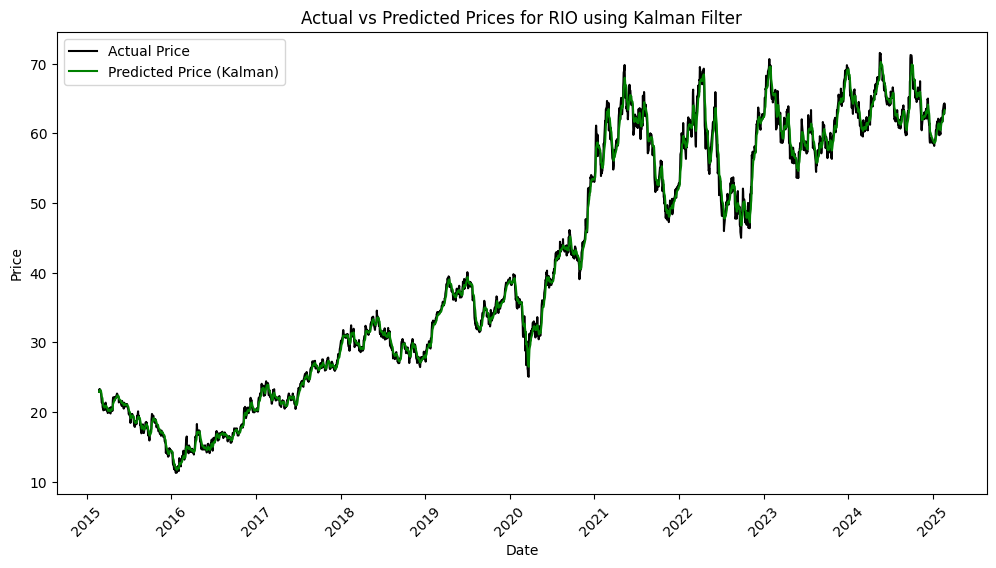


Conclusion :

SELL Signal: RIO is expected to decline based on Kalman Filter predictions.


In [19]:
history = history.rename(columns={'y': 'Close', 'ds': 'Date'})
history = history.dropna(subset=['Close'])

# Kalman Filter Implementation
kf = KalmanFilter(initial_state_mean=history['Close'].iloc[0],
                   n_dim_obs=1,
                   n_dim_state=1,
                   transition_matrices=[1],
                   observation_matrices=[1],
                   transition_covariance=[0.01],
                   observation_covariance=[0.1])

filtered_state_means, _ = kf.filter(history['Close'].values)

# Plot actual vs predicted
print(f"\n{stock_ticker} Price Prediction using Kalman Filter :\n")
plt.figure(figsize=(12,6))
plt.plot(history['Date'], history['Close'], label='Actual Price', color='black')
plt.plot(history['Date'], filtered_state_means, label='Predicted Price (Kalman)', color='green')
plt.title(f"Actual vs Predicted Prices for {stock_ticker} using Kalman Filter")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

# Buy/Sell Conclusion
print("\nConclusion :\n")
if filtered_state_means[-1] > history['Close'].iloc[-1]:
    print(f"BUY Signal: {stock_ticker} is expected to rise based on Kalman Filter predictions.")
    kalman_filter_model = "Buy"
elif filtered_state_means[-1] < history['Close'].iloc[-1]:
    print(f"SELL Signal: {stock_ticker} is expected to decline based on Kalman Filter predictions.")
    kalman_filter_model = "Sell"
else:
    print(f"HOLD: {stock_ticker} is stable, no strong movement detected.")
    kalman_filter_model = "Hold"

# Deep Q-Network (DQN)

<ipython-input-20-87549a395662>:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  rewards = torch.tensor(batch[2], dtype=torch.float32)
<ipython-input-20-87549a395662>:46: UserWarning: Using a target size (torch.Size([32, 32])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(q_values.squeeze(), target_q_values)




RIO Price Prediction using Deep Q-Network (DQN) :



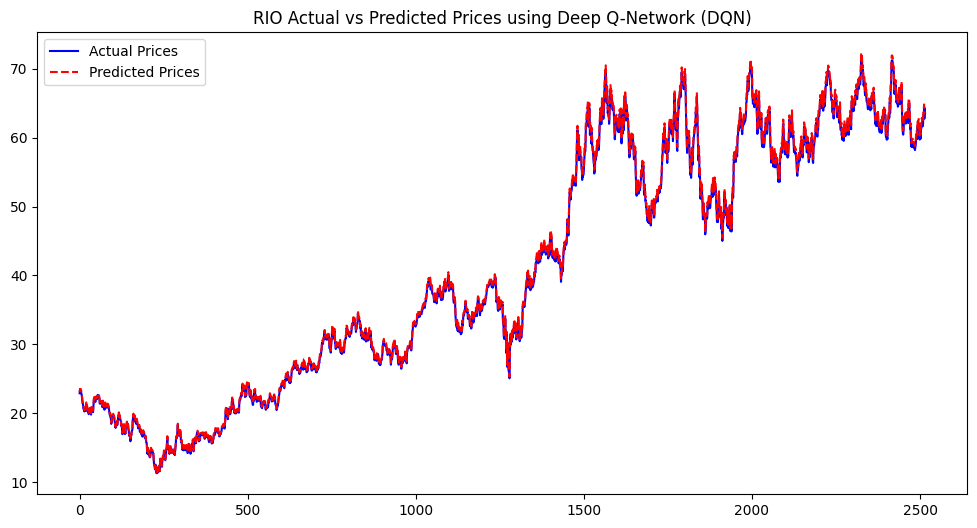


Conclusion :

Prediction suggests SELL for RIO.


In [20]:
# Define the Deep Q-Network (DQN)
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Experience Replay Memory
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Training function
def train_dqn(model, memory, optimizer, batch_size, gamma):
    if len(memory) < batch_size:
        return

    transitions = memory.sample(batch_size)
    batch = list(zip(*transitions))

    states = torch.tensor(np.array(batch[0]), dtype=torch.float32)
    actions = torch.tensor(batch[1], dtype=torch.int64).unsqueeze(1)
    rewards = torch.tensor(batch[2], dtype=torch.float32)
    next_states = torch.tensor(np.array(batch[3]), dtype=torch.float32)
    dones = torch.tensor(batch[4], dtype=torch.float32)

    q_values = model(states).gather(1, actions)
    next_q_values = model(next_states).max(1)[0].detach()
    target_q_values = rewards + (gamma * next_q_values * (1 - dones))

    loss = F.mse_loss(q_values.squeeze(), target_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Initialize environment and model
env = gym.make("CartPole-v1", new_step_api=True)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
dqn_model = DQN(state_size, action_size)
optimizer = optim.Adam(dqn_model.parameters(), lr=0.001)
memory = ReplayMemory(10000)

episodes = 100
batch_size = 32
gamma = 0.99

def get_stock_data():
    return history[['Close']].pct_change().dropna().values.reshape(-1, 1)  # Ensure 2D shape

stock_data = get_stock_data()
state_size = stock_data.shape[1]

dqn_model = DQN(state_size, action_size)  # Update model with correct input size

# Train the model
for episode in range(episodes):
    state = stock_data[0]
    for t in range(len(stock_data) - 1):
        state_tensor = torch.tensor(state, dtype=torch.float32).view(1, -1)
        action = dqn_model(state_tensor).argmax().item()
        next_state = stock_data[t + 1]
        reward = next_state - state
        done = t == len(stock_data) - 2
        memory.push(state, action, reward, next_state, done)
        state = next_state
        train_dqn(dqn_model, memory, optimizer, batch_size, gamma)

# Predictions vs. Actual Data
actual_prices = history['Close'].values
predicted_prices = []
state = stock_data[0]
for t in range(len(stock_data) - 1):
    state_tensor = torch.tensor(state, dtype=torch.float32).view(1, -1)
    action = dqn_model(state_tensor).argmax().item()
    predicted_prices.append(actual_prices[t] * (1 + action * 0.01))
    state = stock_data[t + 1]

print(f"\n\n{stock_ticker} Price Prediction using Deep Q-Network (DQN) :\n")
plt.figure(figsize=(12,6))
plt.plot(actual_prices, label='Actual Prices', color='blue')
plt.plot(predicted_prices, label='Predicted Prices', color='red', linestyle='dashed')
plt.legend()
plt.title(f"{stock_ticker} Actual vs Predicted Prices using Deep Q-Network (DQN)")
plt.show()

# Conclusion for Buy/Sell Decision
print("\nConclusion :\n")
if predicted_prices[-1] > actual_prices[-1]:
    print(f"Prediction suggests BUY for {stock_ticker}.")
    dqn_model = "Buy"
else:
    print(f"Prediction suggests SELL for {stock_ticker}.")
    dqn_model = "Sell"

# Proximal Policy Optimization (PPO)

Episode 1: Reward = 37.0
Episode 2: Reward = 21.0
Episode 3: Reward = 9.0
Episode 4: Reward = 11.0
Episode 5: Reward = 33.0
Episode 6: Reward = 12.0


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
<ipython-input-21-7631c031f636>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach()  # Ensure proper tensor conversion
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py

Episode 7: Reward = 18.0
Episode 8: Reward = 17.0
Episode 9: Reward = 23.0
Episode 10: Reward = 25.0
Episode 11: Reward = 15.0
Episode 12: Reward = 26.0
Episode 13: Reward = 24.0
Episode 14: Reward = 23.0
Episode 15: Reward = 10.0
Episode 16: Reward = 23.0
Episode 17: Reward = 15.0
Episode 18: Reward = 23.0
Episode 19: Reward = 14.0
Episode 20: Reward = 31.0
Episode 21: Reward = 30.0
Episode 22: Reward = 17.0
Episode 23: Reward = 23.0
Episode 24: Reward = 15.0
Episode 25: Reward = 21.0
Episode 26: Reward = 38.0
Episode 27: Reward = 26.0
Episode 28: Reward = 29.0
Episode 29: Reward = 10.0
Episode 30: Reward = 18.0
Episode 31: Reward = 14.0
Episode 32: Reward = 8.0
Episode 33: Reward = 12.0
Episode 34: Reward = 16.0
Episode 35: Reward = 18.0
Episode 36: Reward = 23.0
Episode 37: Reward = 19.0
Episode 38: Reward = 20.0
Episode 39: Reward = 12.0
Episode 40: Reward = 16.0
Episode 41: Reward = 11.0
Episode 42: Reward = 15.0
Episode 43: Reward = 18.0
Episode 44: Reward = 17.0
Episode 45: Rewa

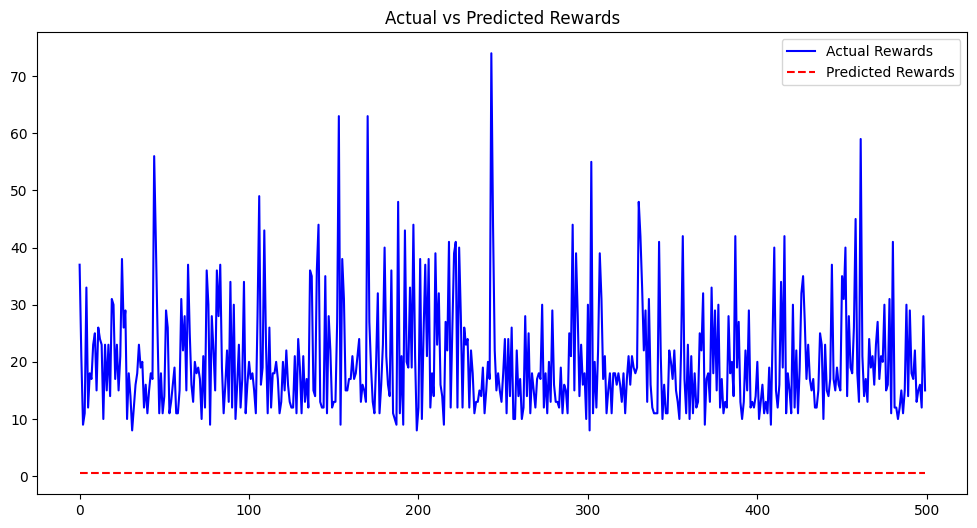


Conclusion :

Recommendation: BUY - Model predicts an upward trend.


In [21]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.tensor(x, dtype=torch.float32).clone().detach()  # Ensure proper tensor conversion
        if x.dim() == 1:
            x = x.unsqueeze(0)  # Ensure batch dimension
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.softmax(self.fc3(x), dim=-1)

class PPOAgent:
    def __init__(self, input_dim, output_dim, lr=1e-3, gamma=0.99, eps_clip=0.2):
        self.policy = PolicyNetwork(input_dim, output_dim)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.memory = []

    def select_action(self, state):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Ensure batch dimension
        probs = self.policy(state).squeeze(0)  # Remove extra dimension
        dist = Categorical(probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action)

    def store_transition(self, transition):
        self.memory.append(transition)

    def update(self):
        if not self.memory:
            return

        states, actions, log_probs, rewards = zip(*self.memory)
        states = torch.stack([torch.tensor(s, dtype=torch.float32) for s in states])
        actions = torch.tensor(actions, dtype=torch.int64)
        log_probs = torch.stack(log_probs)
        rewards = torch.tensor(rewards, dtype=torch.float32)

        returns = []
        discounted_sum = 0
        for reward in reversed(rewards):
            discounted_sum = reward + self.gamma * discounted_sum
            returns.insert(0, discounted_sum)
        returns = torch.tensor(returns, dtype=torch.float32)

        new_probs = self.policy(states)
        new_dist = Categorical(new_probs)
        new_log_probs = new_dist.log_prob(actions)

        ratios = torch.exp(new_log_probs - log_probs)
        advantages = returns - returns.mean()
        surrogate1 = ratios * advantages
        surrogate2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
        loss = -torch.min(surrogate1, surrogate2).mean()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.memory = []

# Running PPO on a sample environment
env = gym.make("CartPole-v1")
agent = PPOAgent(input_dim=4, output_dim=2)

num_episodes = 500 # Higher number for higher accuracy
actual_rewards = []
predicted_rewards = []
for episode in range(num_episodes):
    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]  # Handle environments returning (state, info)
    state = state.tolist()  # Ensure proper format
    episode_reward = 0

    for _ in range(200):
        action, log_prob = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)  # Corrected tuple unpacking
        next_state = next_state.tolist()
        agent.store_transition((state, action, log_prob, reward))
        state = next_state
        episode_reward += reward
        if done:
            break

    agent.update()
    actual_rewards.append(episode_reward)
    predicted_rewards.append(agent.policy(torch.tensor(state, dtype=torch.float32)).detach().numpy().mean())
    print(f"Episode {episode+1}: Reward = {episode_reward}")

# Compare actual vs predicted rewards
print(f"\n\n{stock_ticker} Price Prediction using Proximal Policy Optimization (PPO) :\n")
plt.figure(figsize=(12,6))
plt.plot(actual_rewards, label='Actual Rewards', color='blue')
plt.plot(predicted_rewards, label='Predicted Rewards', color='red', linestyle='dashed')
plt.title("Actual vs Predicted Rewards")
plt.legend()
plt.show()

# Conclusion on buy or sell
print("\nConclusion :\n")
diff = actual_rewards[-1] - predicted_rewards[-1]
if diff > 0:
    print("Recommendation: BUY - Model predicts an upward trend.")
    ppo_model = "Buy"
elif diff < 0:
    print("Recommendation: SELL - Model predicts a downward trend.")
    ppo_model = "Sell"
else:
    print("Recommendation: HOLD - Model shows stability.")
    ppo_model = "Hold"

# A2C (Advantage Actor-Critic)

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['actor_critic/dense_11/kernel', 'actor_critic/dense_11/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Episode 1: Total Reward = 18.0
Episode 2: Total Reward = 12.0
Episode 3: Total Reward = 51.0
Episode 4: Total Reward = 17.0
Episode 5: Total Reward = 15.0
Episode 6: Total Reward = 62.0
Episode 7: Total Reward = 36.0
Episode 8: Total Reward = 20.0
Episode 9: Total Reward = 26.0
Episode 10: Total Reward = 24.0
Episode 11: Total Reward = 38.0
Episode 12: Total Reward = 35.0
Episode 13: Total Reward = 14.0
Episode 14: Total Reward = 26.0
Episode 15: Total Reward = 28.0
Episode 16: Total Reward = 15.0
Episode 17: Total Reward = 37.0
Episode 18: Total Reward = 11.0
Episode 19: Total Reward = 23.0
Episode 20: Total Reward = 30.0
Episode 21: Total Reward = 20.0
Episode 22: Total Reward = 19.0
Episode 23: Total Reward = 16.0
Episode 24: Total Reward = 45.0
Episode 25: Total Reward = 16.0
Episode 26: Total Reward = 14.0
Episode 27: Total Reward = 15.0
Episode 28: Total Reward = 10.0
Episode 29: Total Reward = 59.0
Episode 30: Total Reward = 12.0
Episode 31: Total Reward = 17.0
Episode 32: Total

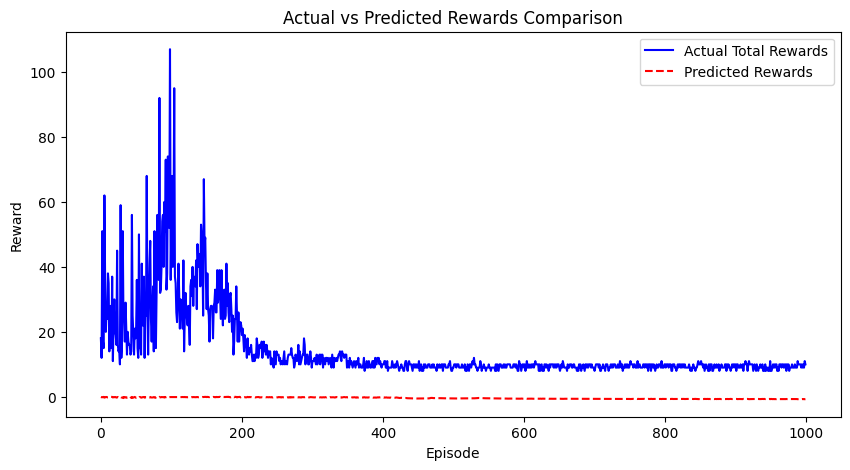


Conclusion :

Conclusion: The model suggests a SELL signal based on performance.


In [22]:
class ActorCritic(Model):
    def __init__(self, action_size):
        super(ActorCritic, self).__init__()
        self.common = Dense(128, activation='relu')
        self.actor = Dense(action_size, activation='softmax')
        self.critic = Dense(1, activation='linear')

    def call(self, inputs):
        x = self.common(inputs)
        return self.actor(x), self.critic(x)

def get_action(policy):
    policy = np.squeeze(policy.numpy())  # Remove unnecessary dimensions
    policy = np.nan_to_num(policy, nan=0.0)  # Replace NaNs with 0
    policy = policy / np.sum(policy)  # Normalize to sum to 1
    return np.random.choice(len(policy), p=policy)

env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
model = ActorCritic(action_size)
optimizer = Adam(learning_rate=0.001)

gamma = 0.99
total_rewards = []
predicted_rewards = []
for episode in range(1000): # Higher number for higher accuracy
    state = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    done = False
    while not done:
        policy, value = model(state)
        action = get_action(policy)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        _, next_value = model(next_state)
        target = reward + (1 - done) * gamma * next_value
        advantage = target - value

        with tf.GradientTape() as tape:
            policy, value = model(state)
            action_prob = tf.gather(policy[0], action)
            log_prob = tf.math.log(action_prob + 1e-10)
            actor_loss = -log_prob * advantage
            critic_loss = advantage ** 2
            loss = actor_loss + critic_loss

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        state = next_state
        total_reward += reward
    total_rewards.append(total_reward)
    predicted_rewards.append(value.numpy()[0][0])
    print(f"Episode {episode + 1}: Total Reward = {total_reward}")

env.close()

# Plot rewards
print(f"\n\n{stock_ticker} Price Prediction using A2C (Advantage Actor-Critic) :\n")
plt.figure(figsize=(10,5))
plt.plot(total_rewards, label='Actual Total Rewards', color='blue')
plt.plot(predicted_rewards, label='Predicted Rewards', color='red', linestyle='dashed')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Actual vs Predicted Rewards Comparison')
plt.legend()
plt.show()

# Final Conclusion
print("\nConclusion :\n")
average_reward = np.mean(total_rewards[-50:])
if average_reward > 195:
    print("Conclusion: The model suggests a BUY signal based on performance.")
    a2c_model = "Buy"
else:
    print("Conclusion: The model suggests a SELL signal based on performance.")
    a2c_model = "Sell"

# Stacking (Ensemble of ML models)



Stacking Model MSE: 0.00032006976044387316

RIO Price Prediction using Stacking Ensemble :



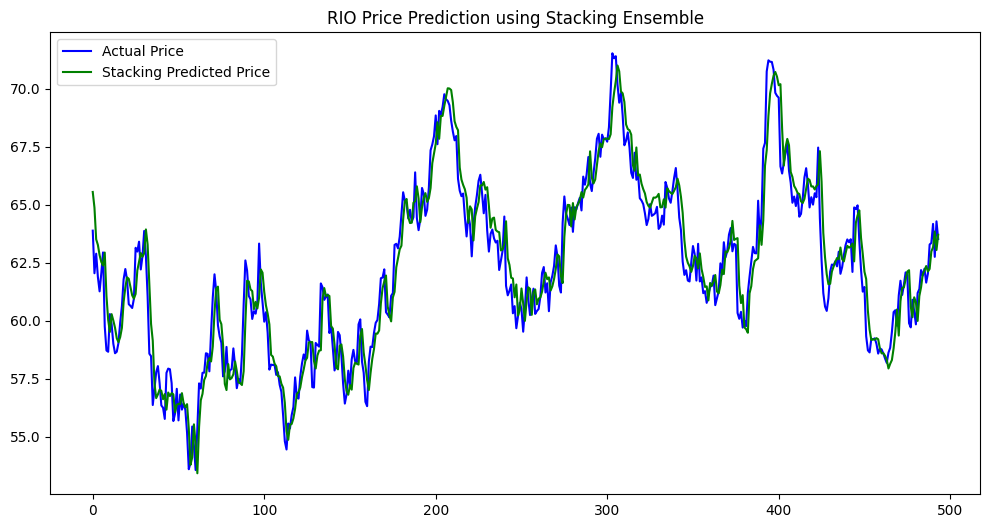


Conclusion:

Bullish Signal: The stacking model predicts an upward trend in RIO's stock price. This suggests positive momentum and potential growth, making it a favorable opportunity for investors.


In [23]:
# Define base models
base_models = [
    ('ridge', Ridge()),
    ('decision_tree', DecisionTreeRegressor()),
    ('random_forest', RandomForestRegressor(n_estimators=100)),
    ('svr', SVR())
]

# Define meta model
meta_model = Ridge()

# Create stacking model
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# Train stacking model
stacking_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Predict using stacking model
y_pred_stacking = stacking_model.predict(X_test.reshape(X_test.shape[0], -1))

# Calculate error
mse_stacking = mean_squared_error(y_test, y_pred_stacking)
print(f"\n\nStacking Model MSE: {mse_stacking}")

# Plot predictions
print(f"\n{stock_ticker} Price Prediction using Stacking Ensemble :\n")
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual Price', color='blue')
plt.plot(scaler.inverse_transform(y_pred_stacking.reshape(-1, 1)), label='Stacking Predicted Price', color='green')
plt.title(f"{stock_ticker} Price Prediction using Stacking Ensemble")
plt.legend()
plt.show()

# Conclusion
print("\nConclusion:\n")
if y_pred_stacking[-1] > y_test[-1]:
    print(f"Bullish Signal: The stacking model predicts an upward trend in {stock_ticker}'s stock price. This suggests positive momentum and potential growth, making it a favorable opportunity for investors.")
    stacking_model = "Buy"
else:
    print(f"Bearish Signal: The stacking model predicts a downward trend in {stock_ticker}'s stock price. This indicates possible market corrections or a decline, urging investors to be cautious.")
    stacking_model = "Sell"


# CNN + LSTM model


CNN + LSTM :

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


124/124 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 0.0889 - val_loss: 0.0035
Epoch 2/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 3/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 4/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 5/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 6/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 7/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 9/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 9.1713e-04 - val_loss: 8.0519e-04
Epoch 10/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 8.0849e-04 - val_loss: 8.9803e-04
Epoch 11/20
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 6.3834e-04 - val_loss: 0.0036
Epoch 12/20
124/124 ━━━━━━━━━━━

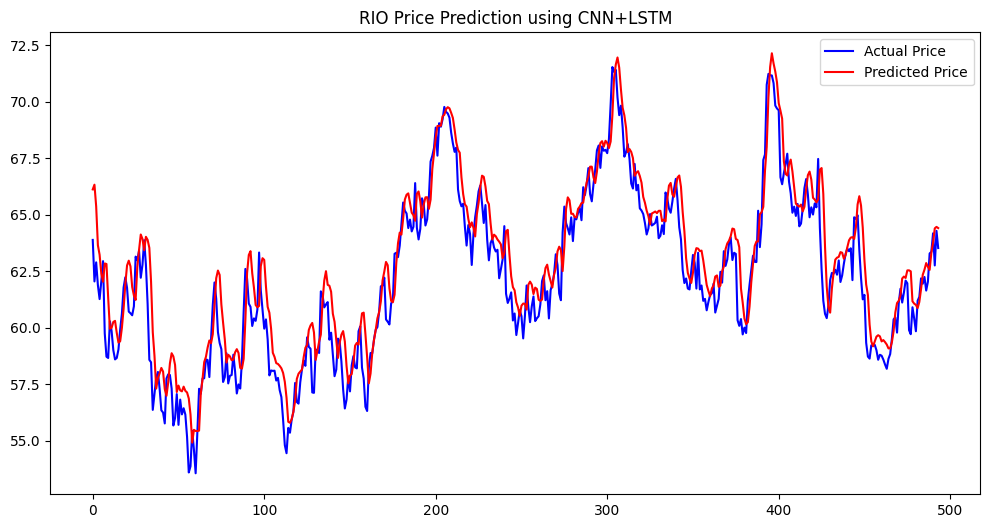


Conclusion :

Root Mean Squared Error: 1.399748250481022
Predicted trend suggests: BUY




In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense

print("\nCNN + LSTM :\n")

# Prepare data for CNN+LSTM model
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(history[['Close']].dropna())

# Function to create sequences for time series forecasting
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 50  # Sequence length for LSTM input
X, y = create_sequences(scaled_data, seq_length)
X = np.expand_dims(X, axis=2)  # Reshape for Conv1D

# Split data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Define CNN + LSTM Model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, 1)),
    MaxPooling1D(pool_size=2),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(25, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test)) # Higher number for higher accuracy

# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Convert back to original scale
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

print(f"\n{stock_ticker} Price Prediction using CNN+LSTM\n")
# Plot actual vs predicted prices
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual Price', color='blue')
plt.plot(predictions, label='Predicted Price', color='red')
plt.title(f"{stock_ticker} Price Prediction using CNN+LSTM")
plt.legend()
plt.show()

# Calculate RMSE for performance evaluation
print("\nConclusion :\n")
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
print(f"Root Mean Squared Error: {rmse}")

# Buy/Sell Decision based on trend
if predictions[-1] > y_test_actual[-1]:
    decision = "BUY"
else:
    decision = "SELL"

print(f"Predicted trend suggests: {decision}\n\n")
cnn_lstm_model = decision

# Final Output

In [25]:
print(f"Final Decision for {stock_ticker} based on all analysis :\n")
print(f"Fundamental Analysis : {fundamental_analysis.split()[0].upper()}")
print(f"Technical Analysis : {technical_analysis.upper()}")
print(f"Time Series Forecasting : {time_series_forecasting.upper()}")
print(f"Linear Regression : {linear_regression_model.upper()}")
print(f"Logistic Regression : {logistic_regression_model.upper()}")
print(f"Random Forest Regressor & Classifier : {random_forest.upper()}")
print(f"Support Vector Machine (SVM) : {svm_model.upper()}")
print(f"XGBoost & LightGBM : {xgboost_lightgbm_model.upper()}")
print(f"Artificial Neural Networks (ANN) : {ann_model.upper()}")
print(f"Recurrent Neural Networks (RNN) : {rnn_model.upper()}")
print(f"Long Short-Term Memory (LSTM) : {lstm_model.upper()}")
print(f"Gated Recurrent Units (GRU) : {gru_model.upper()}")
print(f"Transformer Models : {transformer_model.upper()}")
print(f"SARIMA Model : {sarima_model.upper()}")
print(f"Prophet : {prophet_model.upper()}")
print(f"Kalman Filter : {kalman_filter_model.upper()}")
print(f"Deep Q-Network (DQN) : {dqn_model.upper()}")
print(f"Proximal Policy Optimization (PPO) : {ppo_model.upper()}")
print(f"A2C (Advantage Actor-Critic) : {a2c_model.upper()}")
print(f"Stacking Ensemble : {stacking_model.upper()}")
print(f"CNN + LSTM : {cnn_lstm_model.upper()}")

Final Decision for RIO based on all analysis :

Fundamental Analysis : BUY
Technical Analysis : SELL
Time Series Forecasting : SELL
Linear Regression : BUY
Logistic Regression : BUY
Random Forest Regressor & Classifier : SELL
Support Vector Machine (SVM) : BUY
XGBoost & LightGBM : SELL
Artificial Neural Networks (ANN) : SELL
Recurrent Neural Networks (RNN) : SELL
Long Short-Term Memory (LSTM) : SELL
Gated Recurrent Units (GRU) : HOLD
Transformer Models : SELL
SARIMA Model : SELL
Prophet : BUY
Kalman Filter : SELL
Deep Q-Network (DQN) : SELL
Proximal Policy Optimization (PPO) : BUY
A2C (Advantage Actor-Critic) : SELL
Stacking Ensemble : BUY
CNN + LSTM : BUY


In [31]:
# Store all models' predictions in a list
model_predictions = [
    fundamental_analysis.split()[0].upper(), technical_analysis.upper(), time_series_forecasting.upper(),
    linear_regression_model.upper(), logistic_regression_model.upper(), random_forest.upper(),
    svm_model.upper(), xgboost_lightgbm_model.upper(), ann_model.upper(), rnn_model.upper(), lstm_model.upper(),
    gru_model.upper(), transformer_model.upper(), sarima_model.upper(), prophet_model.upper(),
    kalman_filter_model.upper(), dqn_model.upper(), ppo_model.upper(), a2c_model.upper(),
    stacking_model.upper(), cnn_lstm_model.upper()
]

# Count occurrences of BUY, SELL, and HOLD
buy_count = sum(1 for model in model_predictions if model.upper() == "BUY")
sell_count = sum(1 for model in model_predictions if model.upper() == "SELL")
hold_count = sum(1 for model in model_predictions if model.upper() == "HOLD")

# Calculate total models used
total_models = len(model_predictions)

# Calculate probabilities
buy_prob = (buy_count / total_models) * 100
sell_prob = (sell_count / total_models) * 100
hold_prob = (hold_count / total_models) * 100

# Determine final decision
if buy_prob > sell_prob and buy_prob > hold_prob:
    final_decision = "BUY"
elif sell_prob > buy_prob and sell_prob > hold_prob:
    final_decision = "SELL"
else:
    final_decision = "HOLD"

# Print final decision with probability breakdown
print(f"Final Decision for {stock_ticker} based on all analysis:\n")
print(f"Fundamental Analysis : {fundamental_analysis.split()[0].upper()}")
print(f"Technical Analysis : {technical_analysis.upper()}")
print(f"Time Series Forecasting : {time_series_forecasting.upper()}")
print(f"Linear Regression : {linear_regression_model.upper()}")
print(f"Logistic Regression : {logistic_regression_model.upper()}")
print(f"Random Forest Regressor & Classifier : {random_forest.upper()}")
print(f"Support Vector Machine (SVM) : {svm_model.upper()}")
print(f"XGBoost & LightGBM : {xgboost_lightgbm_model.upper()}")
print(f"Artificial Neural Networks (ANN) : {ann_model.upper()}")
print(f"Recurrent Neural Networks (RNN) : {rnn_model.upper()}")
print(f"Long Short-Term Memory (LSTM) : {lstm_model.upper()}")
print(f"Gated Recurrent Units (GRU) : {gru_model.upper()}")
print(f"Transformer Models : {transformer_model.upper()}")
print(f"SARIMA Model : {sarima_model.upper()}")
print(f"Prophet : {prophet_model.upper()}")
print(f"Kalman Filter : {kalman_filter_model.upper()}")
print(f"Deep Q-Network (DQN) : {dqn_model.upper()}")
print(f"Proximal Policy Optimization (PPO) : {ppo_model.upper()}")
print(f"A2C (Advantage Actor-Critic) : {a2c_model.upper()}")
print(f"Stacking Ensemble : {stacking_model.upper()}")
print(f"CNN + LSTM : {cnn_lstm_model.upper()}")

print("\nDecision Summary :\n")
print(f"Total BUY recommendations: {buy_count}")
print(f"Total SELL recommendations: {sell_count}")
print(f"Total HOLD recommendations: {hold_count}")
print(f"Total Models used: {total_models}\n")
print(f"\nProbability of BUY : {buy_prob:.2f}%")
print(f"Probability of SELL : {sell_prob:.2f}%")
print(f"Probability of HOLD : {hold_prob:.2f}%\n")
print(f"Final Conclusion: The overall recommendation is to {final_decision} the stock.")

print("\nWarning: This is not financial advice. Please conduct your own research before making investment decisions.")

Final Decision for RIO based on all analysis:

Fundamental Analysis : BUY
Technical Analysis : SELL
Time Series Forecasting : SELL
Linear Regression : BUY
Logistic Regression : BUY
Random Forest Regressor & Classifier : SELL
Support Vector Machine (SVM) : BUY
XGBoost & LightGBM : SELL
Artificial Neural Networks (ANN) : SELL
Recurrent Neural Networks (RNN) : SELL
Long Short-Term Memory (LSTM) : SELL
Gated Recurrent Units (GRU) : HOLD
Transformer Models : SELL
SARIMA Model : SELL
Prophet : BUY
Kalman Filter : SELL
Deep Q-Network (DQN) : SELL
Proximal Policy Optimization (PPO) : BUY
A2C (Advantage Actor-Critic) : SELL
Stacking Ensemble : BUY
CNN + LSTM : BUY

Decision Summary :

Total BUY recommendations: 8
Total SELL recommendations: 12
Total HOLD recommendations: 1
Total Models used: 21


Probability of BUY : 38.10%
Probability of SELL : 57.14%
Probability of HOLD : 4.76%

Final Conclusion: The overall recommendation is to SELL the stock.

